In [131]:
# -*- coding: utf-8 -*-   
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.plotly as py
import plotly.graph_objs as go
from sklearn import linear_model
import plotly.plotly as py
import plotly.graph_objs as go
import re
from scipy import stats

In [132]:
from matplotlib.font_manager import FontProperties
font = FontProperties(fname=r"c:\windows\fonts\SimSun.ttc", size=14)

In [133]:
db = pd.read_excel(r'C:\Users\ren.x.1\Desktop\VS_Pricing\JFM_HC_ePOS.xlsx',encoding='gbk')
db.shape

(25331, 20)

In [134]:
db.dropna(inplace = True)

In [135]:
db.head()

,Date,ProductCode,GCAS_No,ProductName,BrandCode,BrandName,pv,uv,Order_Num,Valid_Num,Sales_Num,Offtake,Sales_Price,Unit_Cost,Total_Cost,Front_Margin,Normal_DM_SPP,Top_DM_SPP,Mechanism,Abnormal
0,2017-01-01,206633,82249713,【京东超市】飘柔洗发水绿茶长效清爽去油家庭装750ml（洗发露 家庭护理系列）,13968,飘柔（Rejoice）,747,483,39,39,50,1646.49,32.929800,26.36,1318.00,0.199509,27.9,27.9,single TPR,normal
1,2017-01-01,206636,82249757,【京东超市】飘柔洗发水杏仁长效柔顺滋养家庭装750ml（洗发露 家庭护理系列）,13968,飘柔（Rejoice）,312,212,20,20,20,658.00,32.900000,26.36,527.20,0.198784,27.9,27.9,single TPR,normal
2,2017-01-01,206661,82245036,【京东超市】潘婷去屑洗发水乳液修护400ml（洗发露 新老包装随机发放）,13877,潘婷（pantene）,2653,2380,12,12,13,369.70,28.438462,31.03,403.39,-0.091128,28.5,26.5,single TPR,normal
3,2017-01-01,206675,82245039,【京东超市】潘婷丝质顺滑去屑洗发露400ML,13877,潘婷（pantene）,173,107,15,15,17,516.97,30.410000,31.03,527.51,-0.020388,28.5,26.5,single TPR,normal
4,2017-01-01,206687,82245051,【京东超市】潘婷洗发水丝质顺滑400ml（洗发露 新老包装随机发送）,13877,潘婷（pantene）,252,146,37,37,61,1589.00,26.049180,31.03,1892.83,-0.191208,28.5,26.5,single TPR,normal


In [136]:
db.BrandName.value_counts()

海飞丝             6134
潘婷（pantene）     6102
飘柔（Rejoice）     4561
沙宣（VS）          3054
伊卡璐（CLAIROL）     898
Name: BrandName, dtype: int64

In [137]:
# df = db[db.BrandName == u'沙宣（VS）']
df = db.copy()

In [138]:
df.head()

,Date,ProductCode,GCAS_No,ProductName,BrandCode,BrandName,pv,uv,Order_Num,Valid_Num,Sales_Num,Offtake,Sales_Price,Unit_Cost,Total_Cost,Front_Margin,Normal_DM_SPP,Top_DM_SPP,Mechanism,Abnormal
0,2017-01-01,206633,82249713,【京东超市】飘柔洗发水绿茶长效清爽去油家庭装750ml（洗发露 家庭护理系列）,13968,飘柔（Rejoice）,747,483,39,39,50,1646.49,32.929800,26.36,1318.00,0.199509,27.9,27.9,single TPR,normal
1,2017-01-01,206636,82249757,【京东超市】飘柔洗发水杏仁长效柔顺滋养家庭装750ml（洗发露 家庭护理系列）,13968,飘柔（Rejoice）,312,212,20,20,20,658.00,32.900000,26.36,527.20,0.198784,27.9,27.9,single TPR,normal
2,2017-01-01,206661,82245036,【京东超市】潘婷去屑洗发水乳液修护400ml（洗发露 新老包装随机发放）,13877,潘婷（pantene）,2653,2380,12,12,13,369.70,28.438462,31.03,403.39,-0.091128,28.5,26.5,single TPR,normal
3,2017-01-01,206675,82245039,【京东超市】潘婷丝质顺滑去屑洗发露400ML,13877,潘婷（pantene）,173,107,15,15,17,516.97,30.410000,31.03,527.51,-0.020388,28.5,26.5,single TPR,normal
4,2017-01-01,206687,82245051,【京东超市】潘婷洗发水丝质顺滑400ml（洗发露 新老包装随机发送）,13877,潘婷（pantene）,252,146,37,37,61,1589.00,26.049180,31.03,1892.83,-0.191208,28.5,26.5,single TPR,normal


In [139]:
df = df[- df.Mechanism.str.contains(u"领券")]

In [140]:
df.columns

Index([u'Date', u'ProductCode', u'GCAS_No', u'ProductName', u'BrandCode',
       u'BrandName', u'pv', u'uv', u'Order_Num', u'Valid_Num', u'Sales_Num',
       u'Offtake', u'Sales_Price', u'Unit_Cost', u'Total_Cost',
       u'Front_Margin', u'Normal_DM_SPP', u'Top_DM_SPP', u'Mechanism',
       u'Abnormal'],
      dtype='object')

In [141]:
df.dtypes

Date             datetime64[ns]
ProductCode               int64
GCAS_No                  object
ProductName              object
BrandCode                 int64
BrandName                object
pv                        int64
uv                        int64
Order_Num                 int64
Valid_Num                 int64
Sales_Num                 int64
Offtake                 float64
Sales_Price             float64
Unit_Cost               float64
Total_Cost              float64
Front_Margin            float64
Normal_DM_SPP           float64
Top_DM_SPP              float64
Mechanism                object
Abnormal                 object
dtype: object

In [142]:
df.Date = pd.to_datetime(df.Date)

In [143]:
def jointplt(ProductCode):
    SKU = df[df['ProductCode'] == ProductCode][['Sales_Price',u'Sales_Num']]
    SKU = SKU.groupby(by = 'Sales_Price',as_index=False).mean()
    #SKU = SKU[SKU.Sales_Num >= 10]
    SKU.Sales_Num = np.log(SKU.Sales_Num)
    SKU.Sales_Price = np.log(SKU[u'Sales_Price'])
    sns.jointplot(x="Sales_Price", y="Sales_Num", kind = 'reg', color = 'r', data=SKU)
    plt.ylim(0,10)
    plt.xlim(3,5)
    #plt.title(SKU_NAME,fontproperties=font)

In [144]:
def statsReg(ProductCode):
    SKU = df[df.ProductCode == ProductCode]
    x = np.log(SKU.Sales_Price)
    y = np.log(SKU.Sales_Num)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    if (p_value < 0.1) and (len(y) >= 5):
        return np.round(slope,decimals=1)
    else:
        return np.nan

In [145]:
PE_Hash_1 = {}
for code in df.ProductCode:
    PE_Hash_1[code] = statsReg(code)

PE_DF_1 =  pd.DataFrame.from_dict(PE_Hash_1, orient='index', dtype=None)
PE_DF_1.columns = ['PE']
PE_DF_1.head()

,PE
844529,-6.5
2907650,NaN
2652486,NaN
2305542,-1.8
2793991,NaN


In [146]:
#PE_DF_1.to_csv(r'C:\Users\ren.x.1\Desktop\VS_Pricing\pePSKU.csv',encoding = 'utf-8')

In [147]:
def statsRegPerMech(ProductCode):
    SKU = df[df.ProductCode == ProductCode]
    PEs = []
    for mech in df.Mechanism.unique():
        SKU_PerMech = SKU[SKU.Mechanism == mech]
        if SKU_PerMech.empty:
            PEs.append('NODATA')
        else:
            x = np.log(SKU_PerMech.Sales_Price)
            y = np.log(SKU_PerMech.Sales_Num)
            slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
            if p_value <= 0.1:
                PEs.append(np.round(slope,decimals=1))
            else:
                PEs.append('NONLINEAR')
    return PEs

In [148]:
PE_Hash = {}
for code in df.ProductCode:
    PE_Hash[code] = statsRegPerMech(code)

In [149]:
PE_DF =  pd.DataFrame.from_dict(PE_Hash, orient='index', dtype=None)
PE_DF.columns = df.Mechanism.unique()
PE_DF.head()

,single TPR,PP,3件7折 4件6折,满199减100,满159减60,满99减30,满199减80
844529,-7.1,NODATA,-5.8,NODATA,-4.5,NONLINEAR,-10.3
2907650,NONLINEAR,NODATA,NODATA,NODATA,NODATA,NODATA,NODATA
2652486,NONLINEAR,NODATA,NODATA,NODATA,NODATA,NODATA,NODATA
2305542,NODATA,-1.8,NODATA,NODATA,NODATA,NODATA,NODATA
2793991,NONLINEAR,NODATA,NODATA,NODATA,NODATA,NODATA,NODATA


In [150]:
# PE_DF.to_csv(r'C:\Users\ren.x.1\Desktop\VS_Pricing\pePSKUPM.csv',encoding = 'utf-8')

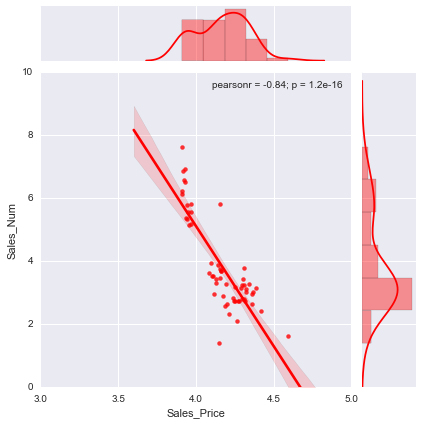

In [151]:
jointplt(206808)

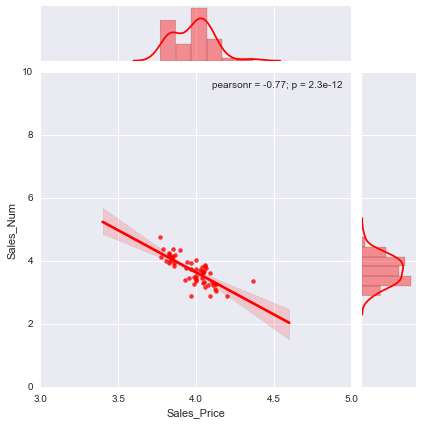

In [152]:
jointplt(1265438)

In [153]:
prodNames = []
for idx in PE_DF_1.index:
    prodNames.append(df[df.ProductCode == idx].ProductName.iloc[0])
PE_DF_1['productName'] = prodNames

In [154]:
margin = []
for idx in PE_DF_1.index:
    margin.append(np.round(float(df[df.ProductCode == idx].Offtake.sum())/df[df.ProductCode == idx].Total_Cost.sum(),decimals=2) - 1)
PE_DF_1['margin'] = margin

In [155]:
averagePrice = []
for idx in PE_DF_1.index:
    averagePrice.append(np.round(float(df[df.ProductCode == idx].Offtake.sum())/df[df.ProductCode == idx].Sales_Num.sum(),decimals=2))
PE_DF_1['averagePrice'] = averagePrice

In [156]:
cost = []
for idx in PE_DF_1.index:
    cost.append(df[df.ProductCode == idx].Unit_Cost.iloc[0])
PE_DF_1['cost'] = cost

In [157]:
mask = (PE_DF_1.margin < - 0.1) & (np.abs(PE_DF_1.PE) < 3)
PE_DF_1[mask]

,PE,productName,margin,averagePrice,cost
2305542,-1.8,【京东超市】潘婷 pantene 乳液修护洗发露500ml+精华素500ml 新老包装随机发送,-0.26,46.64,63.06
301622,-2.4,【京东超市】飘柔护发素人参滋养750ml（润发精华素）,-0.21,32.91,41.58
1093714,-2.3,【京东超市】潘婷（pantene）植物精萃净润养护系列润发精华素700ml（护发素）,-0.23,36.65,47.73
1093694,-2.0,【京东超市】伊卡璐无硅油洗发水迷迭薄荷水润舒缓750ml （洗发露）,-0.18,41.39,50.77
1093700,-2.4,【京东超市】伊卡璐护发素迷迭薄荷水润舒缓750ml（润发乳）,-0.19,39.30,48.66
1093701,-2.0,【京东超市】伊卡璐无硅油洗发水西柚薄荷活力丰盈750ml （洗发露）,-0.16,42.39,50.77
773203,-1.3,【京东超市】海飞丝男士洗发露活力酷爽去屑型380ml（护肤洗发水 新老包装随机发放）,-0.22,31.17,39.85
628068,-2.1,【京东超市】伊卡璐洗发水滋养水润椰果精华750ml（洗发露 新老包装随机发放）,-0.18,41.73,50.77
4071530,-1.0,【京东超市】海飞丝护发素致美水润200ML（头皮精华乳）,-0.46,13.69,25.56
1071724,-2.4,【京东超市】沙宣男士洗发水洁净去屑700ml（洗发露 去屑止痒 控油）,-0.14,67.20,78.10


In [158]:
PE_DF_1.sort(columns=['margin','PE'],ascending=[True,False])

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: FutureWarning:

sort(columns=....) is deprecated, use sort_values(by=.....)



,PE,productName,margin,averagePrice,cost
4071530,-1.0,【京东超市】海飞丝护发素致美水润200ML（头皮精华乳）,-0.46,13.69,25.56
1680529,-4.6,潘婷 pantene 强韧养根润发洗发露750ML,-0.37,32.50,51.88
206757,-6.2,【京东超市】海飞丝去屑护肤洗发水海洋活力型750ml（洗发露 新老包装随机发放）,-0.36,47.94,70.97
2907650,NaN,海飞丝 H&S 去屑洗发露海洋活力型750毫升（12）,-0.36,568.27,851.64
2652486,NaN,【京东超市】沙宣 VS 盈卷修润洗发露750ml（12）,-0.36,609.13,948.84
2793991,NaN,飘柔 Rejoice 高纯焗油润发精华素400ML(6),-0.36,91.17,141.96
2907656,NaN,海飞丝 H&S 男士去屑洗发露净爽去油型380毫升（12）,-0.36,307.03,478.20
2793997,NaN,飘柔 Rejoice 滋润去屑润发精华素400ML（6）,-0.36,91.17,141.96
2794005,NaN,飘柔 Rejoice 焗油护理洗发露750ML（12）,-0.36,341.06,531.36
2793741,NaN,潘婷 Pantene 乌黑莹亮洗发露 200ML（24）,-0.36,261.80,407.76


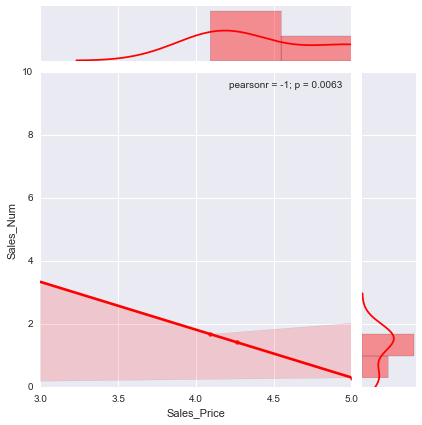

In [159]:
jointplt(2305550)

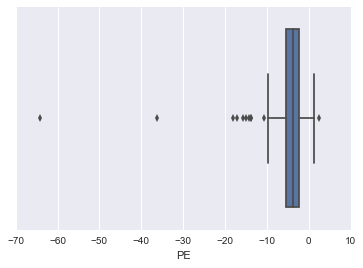

In [160]:
sns.boxplot(y = 'PE',data = PE_DF_1,orient= 'h',saturation=0.75)

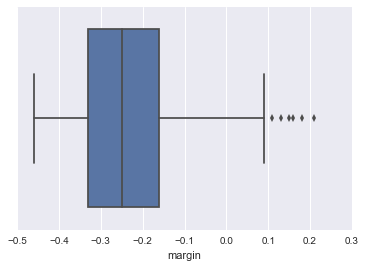

In [161]:
sns.boxplot(y = 'margin',data = PE_DF_1,orient= 'h',saturation=0.75)